<a href="https://colab.research.google.com/github/AbhishekPatil98/Covid-19-Tweet-Analysis/blob/main/Covid_19_Tweet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Title :- Sentiment Analysis : Predicting sentiment of COVID-19 tweets

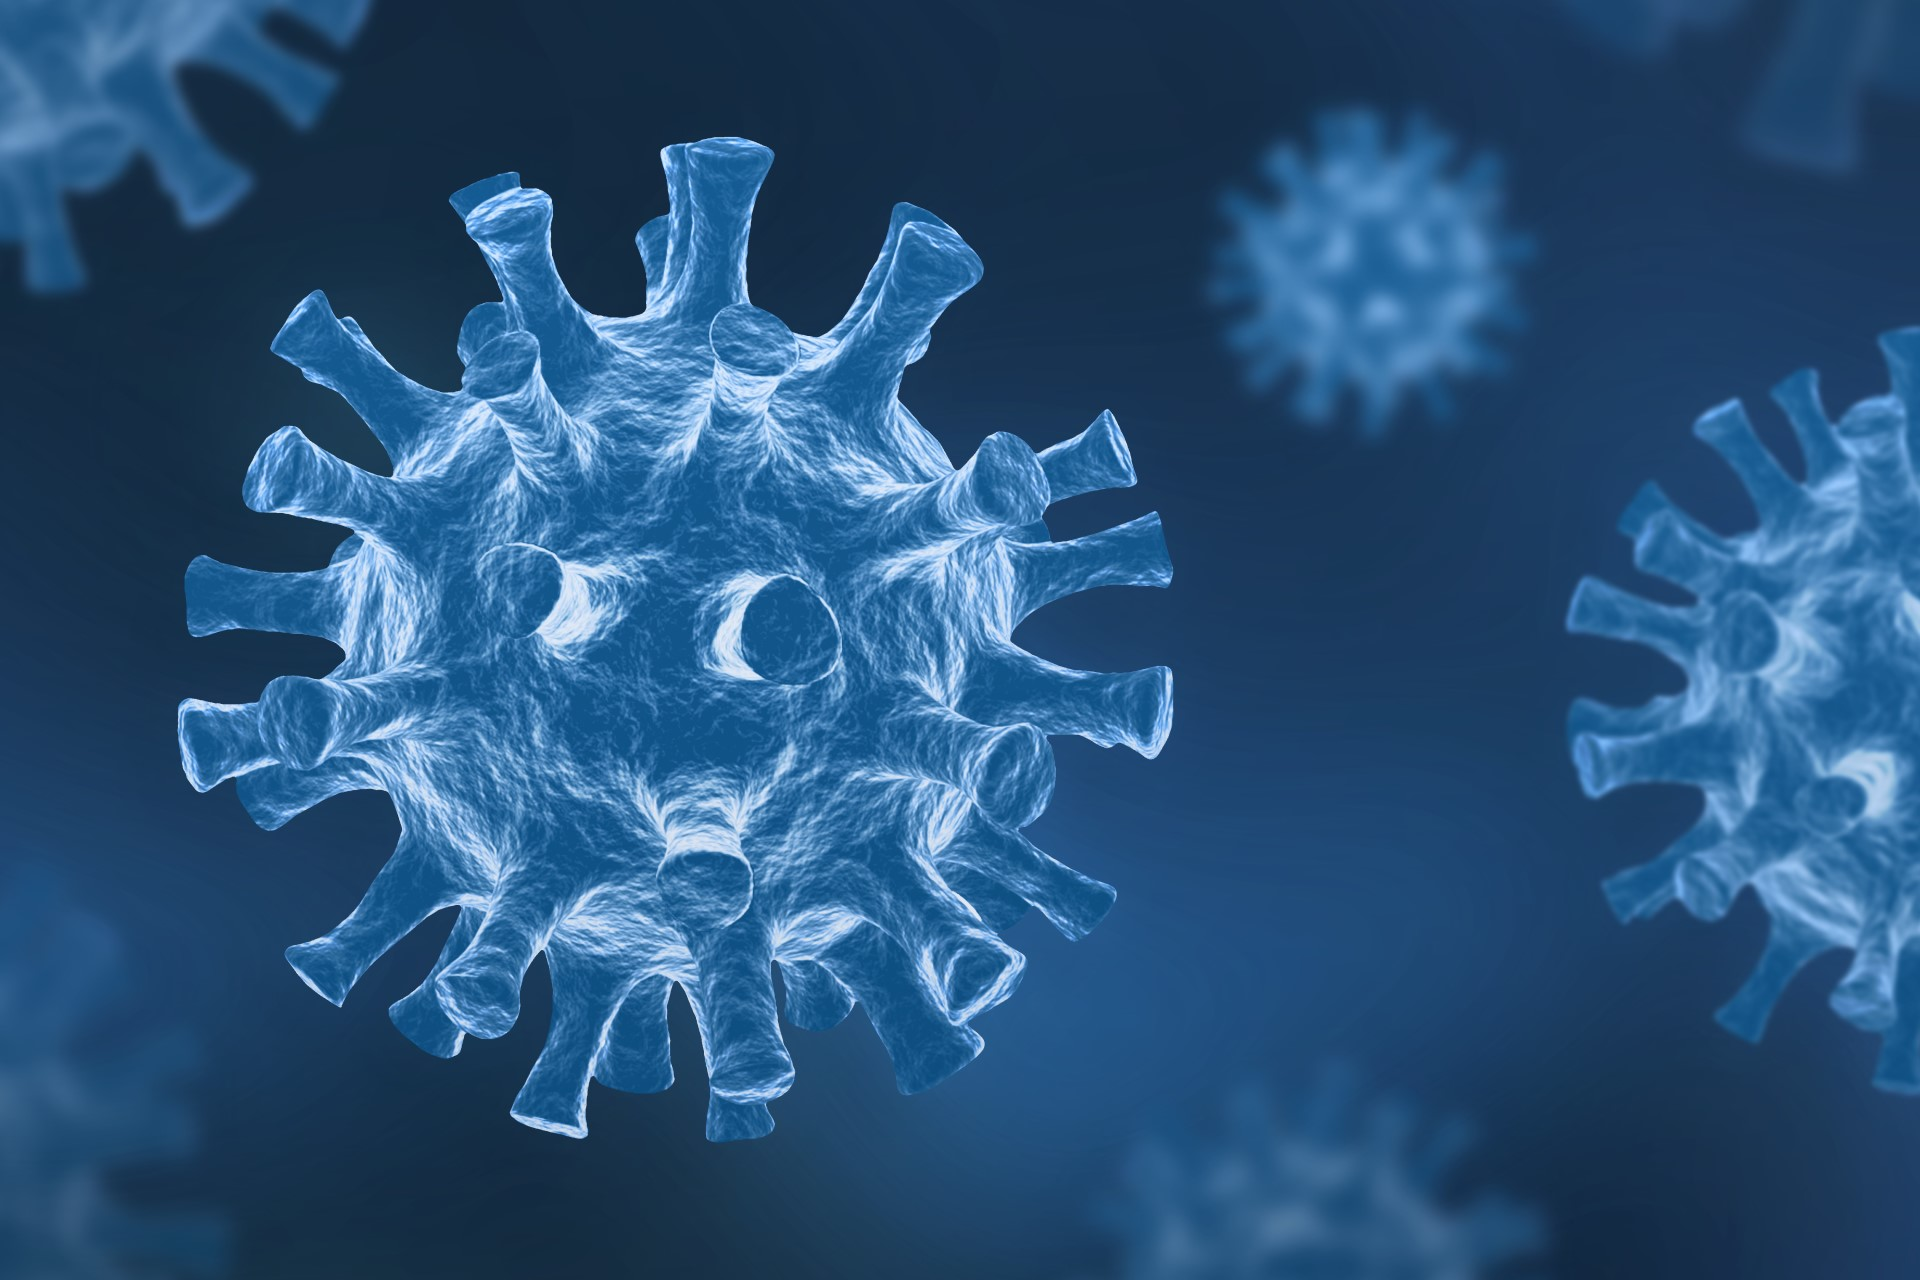

#Problem Description
This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

The names and usernames have been given codes to avoid any privacy concerns.

You are given the following information:

Location
Tweet At
Original Tweet
Label

Import Libraries and Data

In [5]:

# Import necessary libraries

import pandas as pd
import numpy as np
from numpy import math
pd.pandas.set_option('display.max_columns',None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext google.colab.data_table

import re # for regular expressions
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_word = stopwords.words('english') # load stop words
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
import gensim

from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import make_scorer,classification_report,confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import f1_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the data from the file Coronavirus Tweets.csv into a Pandas data frame.

In [6]:

# Mount Drive to load data.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

# Read the csv file
data=pd.read_csv("/content/drive/MyDrive/Coronavirus Tweets.csv",encoding='ISO-8859-1')

First Look

In [8]:

# Fisrt 5 values.
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:

# Last 5 values.
data.tail()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral
41156,44955,89907,i love you so much || he/him,14-04-2020,@TartiiCat Well new/used Rift S are going for ...,Negative


In [10]:

# Check for duplicated entries.
print("Duplicate entry in data:",len(data[data.duplicated()]))

Duplicate entry in data: 0


In [11]:
# Custom Function for Dtype,Unique values and Null values
def datainfo():
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100 
    return temp_ps

In [12]:
# Shape of the data.
print("Total Rows and Columns in DataFrame is :",data.shape,"\n") 
# Custom Function
datainfo()

Total Rows and Columns in DataFrame is : (41157, 6) 



,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
UserName,int64,41157,41157,0,0.000000
ScreenName,int64,41157,41157,0,0.000000
Location,object,32567,12220,8590,20.871298
TweetAt,object,41157,30,0,0.000000
OriginalTweet,object,41157,41157,0,0.000000
Sentiment,object,41157,5,0,0.000000


Here are some statistics for the numerical columns:

In [13]:

# statistics info
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UserName,41157.0,NaN,NaN,NaN,24377.0,11881.146851,3799.0,14088.0,24377.0,34666.0,44955.0
ScreenName,41157.0,NaN,NaN,NaN,69329.0,11881.146851,48751.0,59040.0,69329.0,79618.0,89907.0
Location,32567,12220,London,540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TweetAt,41157,30,20-03-2020,3448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OriginalTweet,41157,41157,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sentiment,41157,5,Positive,11422,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset contains 41157 rows and 2 columns. Each row of the dataset contains information about one tweets.

In [14]:

# dataset contain Text data so its better to convert it into string 
data['OriginalTweet']=data['OriginalTweet'].astype(str)
data['Sentiment']=data['Sentiment'].astype(str)
     


Step 1 - Exploratory Analysis and Visualization
Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

In [15]:

# Separate dataframe for EDA
data_E=data.copy()
     


Missing Values

In [16]:


# 1 -step make the list of features which has missing values
feature_with_na=[feature for feature in data_E.columns if data_E[feature].isnull().sum()>1]
# 2- step print the feature name and the percentage of missing values
for feature in feature_with_na:
  print(feature, np.round(data_E[feature].isnull().mean(), 4)*100,  " % missing values")

Location 20.87  % missing values


In [17]:
# Data has 5 clases of Sentiments,convert them into 3
def classes_con(x):

  if x == 'Extremely Positive':
    return "Positive"
  if x == 'Positive':
    return "Positive"   
  elif x == "'Extremely Negative":
    return "Negative"  
  elif x == "Negative":  
    return "Negative"  
  else:
    return "Neutral" 

data_E["Sentiment"]=data_E["Sentiment"].apply(lambda x:classes_con(x))    

data_E.Sentiment.value_counts()

Positive    18046
Neutral     13194
Negative     9917
Name: Sentiment, dtype: int64

Sentiment Analysis

In [18]:

analysis_1= data_E.groupby("Sentiment").count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
analysis_1

,Sentiment,OriginalTweet
2,Positive,18046
1,Neutral,13194
0,Negative,9917


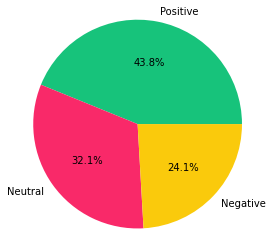

In [19]:

# count plot on Sentiment categorical variable
percent_class = analysis_1['OriginalTweet']
labels= analysis_1.Sentiment
colors = ['#17C37B','#F92969','#FACA0C']
fig=plt.pie(percent_class,labels=labels,colors=colors,autopct="%.1f%%",radius =1.2)

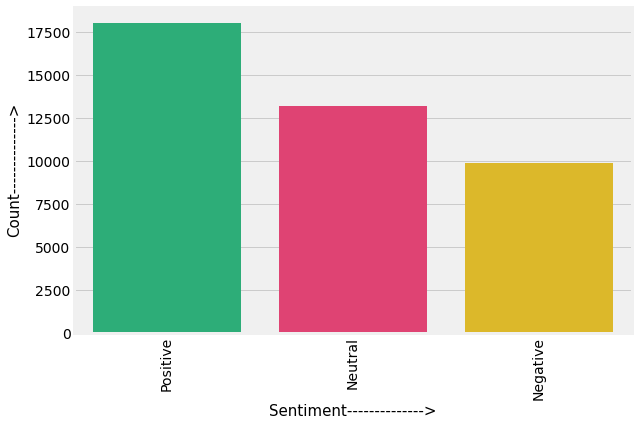

In [20]:
# ploting countplot for "Sentiment" column
plt.figure(figsize=(10,6))
plt.style.use("fivethirtyeight")
sns.countplot('Sentiment',data=data_E,order=data_E.Sentiment.value_counts().index,palette = ['#17C37B','#F92969','#FACA0C'])
plt.xlabel("Sentiment-------------->", fontsize=15)
plt.ylabel("Count-------------->", fontsize=15)
plt.xticks(rotation=90)
plt.show();

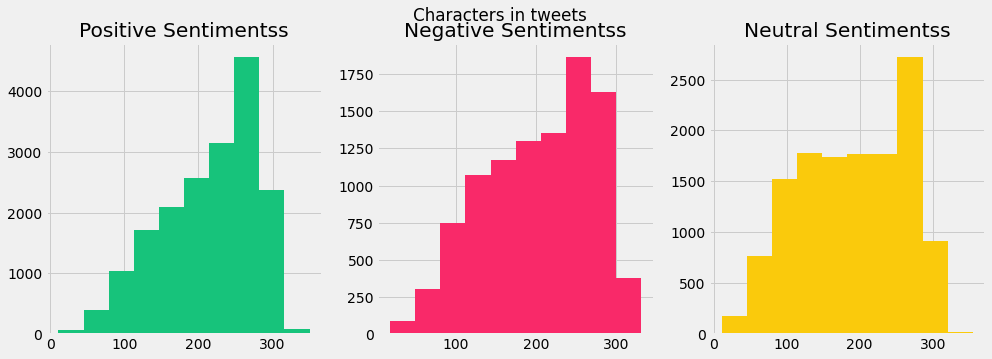

In [21]:
# Histogram
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

# Histogram for Positive Sentiments
tweet_len= data_E[data_E['Sentiment'] == "Positive"]["OriginalTweet"].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentimentss')

# Histogram for Negative Sentiments
tweet_len=data_E[data_E['Sentiment']=="Negative"]['OriginalTweet'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentimentss')

# Histogram for Neutral Sentiments
tweet_len=data_E[data_E['Sentiment']=="Neutral"]['OriginalTweet'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentimentss')

fig.suptitle('Characters in tweets')
plt.show()

Number of words in a tweet

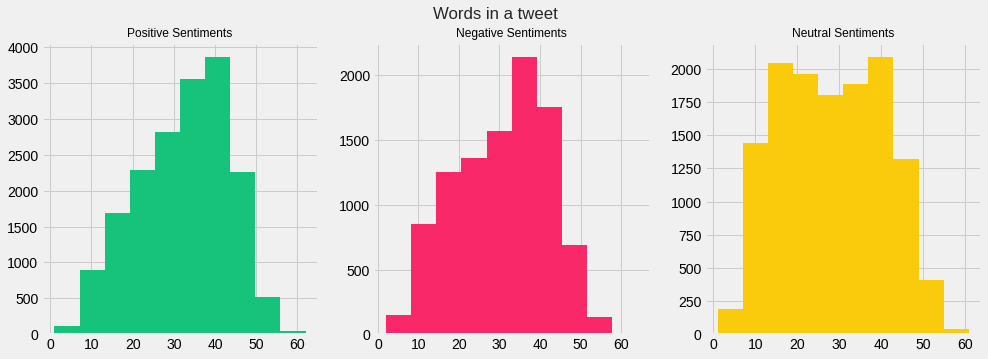

In [22]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
plt.style.use('seaborn')
# Histogram for Positive Sentiments
tweet=data_E[data_E['Sentiment']=="Positive"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax1.hist(tweet,color='#17C37B')
ax1.set_title('Positive Sentiments')

# Histogram for Negative Sentiments
tweet=data_E[data_E['Sentiment']=="Negative"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax2.hist(tweet,color='#F92969')
ax2.set_title('Negative Sentiments')

# Histogram for Neutral Sentiments
tweet=data_E[data_E['Sentiment']=="Neutral"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax3.hist(tweet,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.show()

In [23]:

# Dwonloading stopwords from nltk library 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# Function to create a corpus 
def create_corpus(target):
    corpus=[] 
    for x in data_E[data_E['Sentiment']==target ]['OriginalTweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

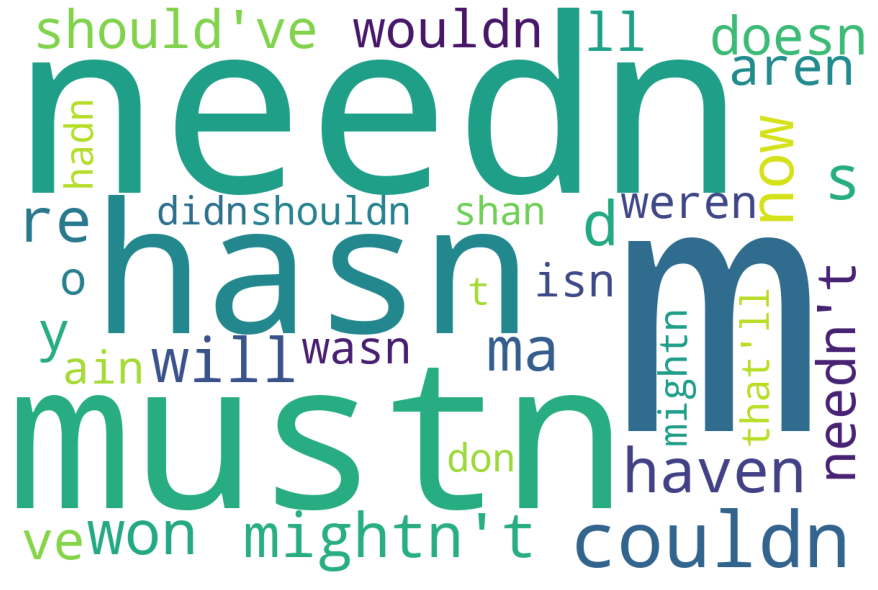

In [25]:
# Cloudword for Stopwords present in dataset

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
comment_words = '' 
stopwords= set(STOPWORDS)

for val in stop:     
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split()   
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()  
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white',
                stopwords = stopwords, 
                min_font_size = 6).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
   

<BarContainer object of 10 artists>

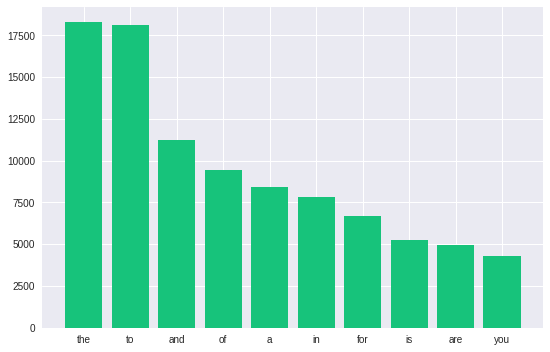

In [26]:
# Stopwords in Positive sentiments
corpus=create_corpus("Positive")
from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')
     

<BarContainer object of 10 artists>

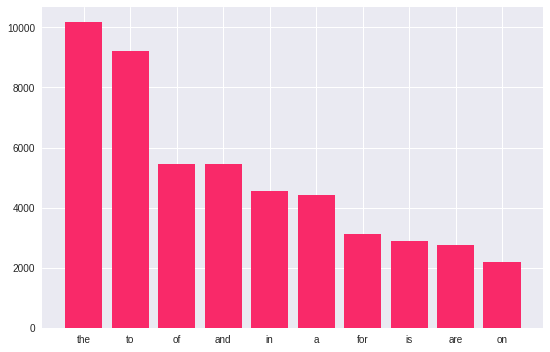

In [27]:
# Stopwords in Negative sentiments
corpus=create_corpus("Negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
          
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#F92969')

<BarContainer object of 10 artists>

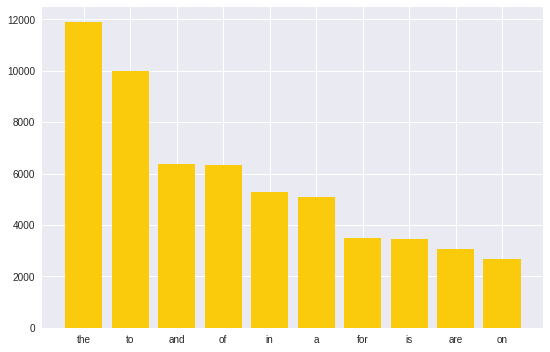

In [28]:
# Stopwords in Neutral sentiments
corpus=create_corpus("Neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
               
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#FACA0C')

Punctuations

<BarContainer object of 27 artists>

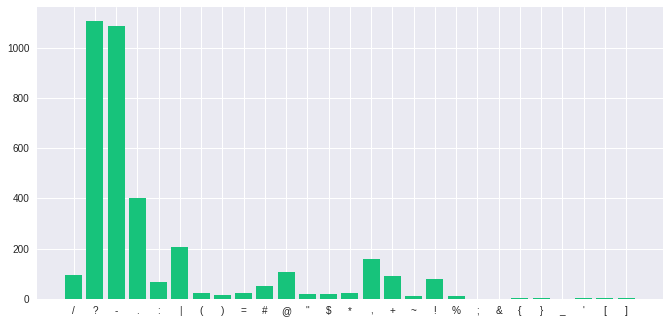

In [29]:

# Punctuations in Positive sentiments
plt.figure(figsize=(10,5))
corpus=create_corpus("Positive")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='#17C37B')

<BarContainer object of 23 artists>

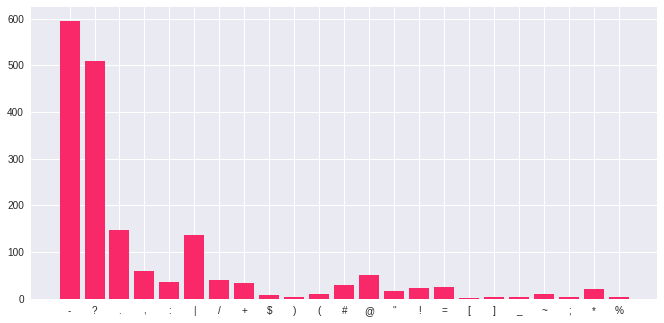

In [30]:
# Punctuations in Negative sentiments
plt.figure(figsize=(10,5))
corpus=create_corpus("Negative")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
                
x,y=zip(*dic.items())
plt.bar(x,y, color='#F92969')
     

<BarContainer object of 26 artists>

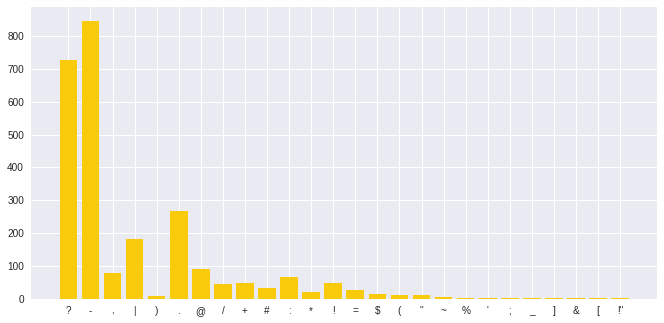

In [31]:
# Punctuations in Neutral sentiments
plt.figure(figsize=(10,5))
corpus=create_corpus("Neutral")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

        
x,y=zip(*dic.items())
plt.bar(x,y,color='#FACA0C')

Common Words

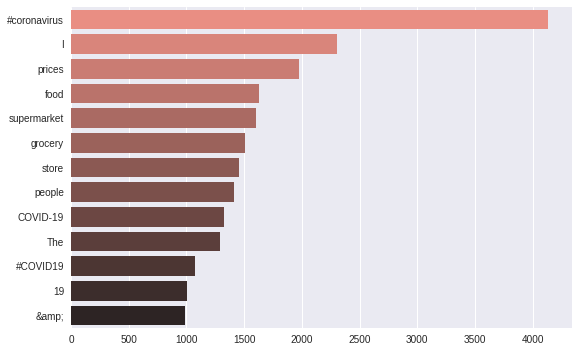

In [32]:

# Barplot for common words
from collections import Counter
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x,palette="dark:salmon_r");    

Hashtags

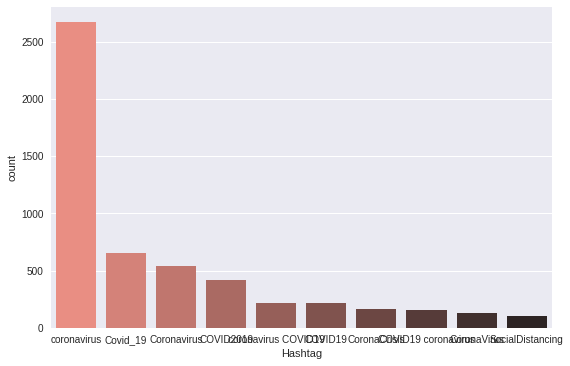

In [33]:

import re 
def find_hash(OriginalTweet):
    line=re.findall(r'(?<=#)\w+',OriginalTweet)
    return " ".join(line)
data_E['hash']=data_E['OriginalTweet'].apply(lambda x:find_hash(x))
temp=data_E['hash'].value_counts()[:][1:11]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})
sns.barplot(x="Hashtag",y="count", data = temp,palette="dark:salmon_r")

Mentions

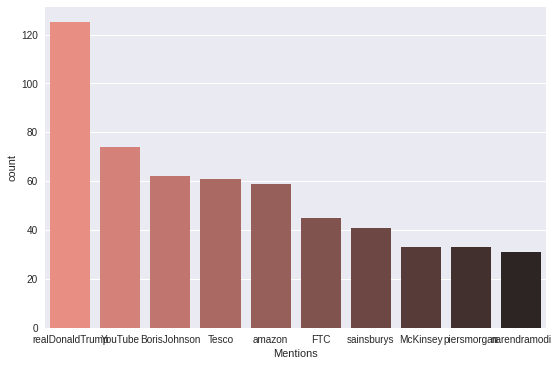

In [34]:

def mentions(OriginalTweet):
    line=re.findall(r'(?<=@)\w+',OriginalTweet)
    return " ".join(line)
data_E['mentions']=data_E['OriginalTweet'].apply(lambda x:mentions(x))

temp=data_E['mentions'].value_counts()[:][1:11]
temp =temp.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

sns.barplot(x="Mentions",y="count", data = temp,palette="dark:salmon_r")

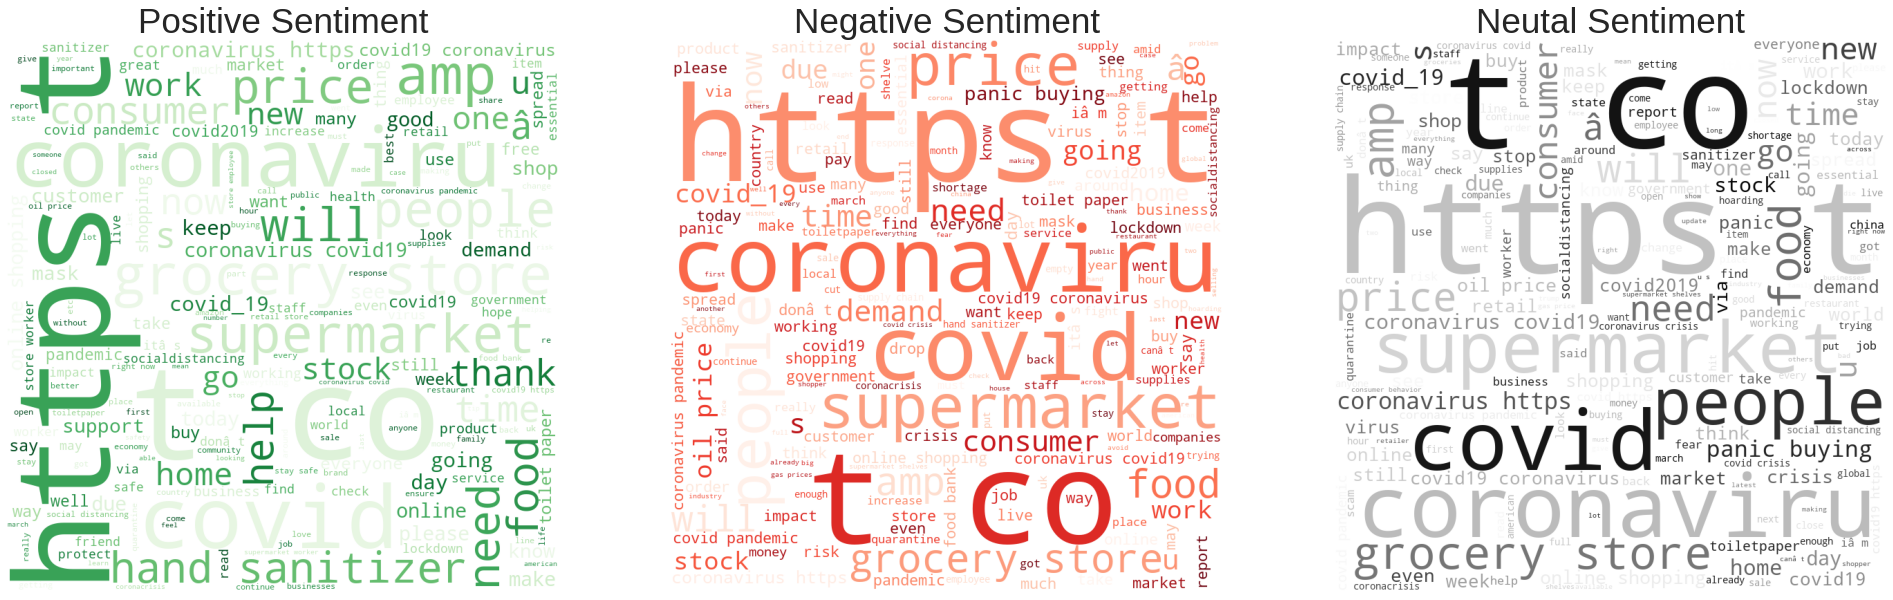

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

data_pos = data_E[data_E["Sentiment"]=="Positive"]
data_neg = data_E[data_E["Sentiment"]=="Negative"]
data_neu = data_E[data_E["Sentiment"]=="Neutral"]

comment_words = '' 
stopwords = set(STOPWORDS) 

for val in data_pos.OriginalTweet: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
   

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

comment_words = ''

for val in data_neg.OriginalTweet: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "




wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)  
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);



comment_words = ''
for val in data_neu.OriginalTweet: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);
     


Step 2 - Data Preprocessing
Before we can train the model, we need to prepare the dataset. Here are the steps we'll follow:

Multiclass Classification

In [36]:

# Filter columns
data_M=data[["OriginalTweet","Sentiment"]]

In [37]:
# Conversion of sentiments
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 1
    elif sentiment == "Positive":
        return 1
    elif sentiment == "Extremely Negative":
        return 0
    elif sentiment == "Negative":
        return 0
    else:
        return 2

data_M['Sentiment'] = data_M['Sentiment'].apply(lambda x: change_sen(x))   
     

In [38]:
# Function to clean the text
def clean(text):

    #     remove urls
    text = re.sub(r'http\S+', " ", text)

    #     remove mentions
    text = re.sub(r'@\w+',' ',text)

    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)

    #     remove digits
    text = re.sub(r'\d+', ' ', text)

    #     remove html tags
    text = re.sub('r<.*?>',' ', text)
    
    #     remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
    
    #     convert to lower case
    text = text.lower()
      
    return text

data_M['OriginalTweet'] = data_M['OriginalTweet'].apply(lambda x: clean(x))


Training and Validation Set for Multi class Classification
Finally, let's split the dataset into a training and validation set. We'll use a randomly select 25% subset of the data for validation. Also, we'll use just the numeric and encoded columns, since the inputs to our model must be numbers.

In [39]:
# Import train_test_split from sklearn library to make split of data_M into train sets and validation sets
from sklearn.model_selection import train_test_split
train,valid = train_test_split(data_M,test_size = 0.2,random_state=0,stratify = data_M.Sentiment.values) 
#stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input data_Mset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (32925, 2)
valid shape :  (8232, 2)


Use Of Counter Vectorizer For Multi Class Classification

In [40]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

train_inputs = vectorizer.fit_transform(train.OriginalTweet.values)
val_inputs = vectorizer.transform(valid.OriginalTweet.values)

train_targets = train.Sentiment.values
val_targets = valid.Sentiment.values

print("train_inputs.shape : ", train_inputs.shape)
print("val_inputs.shape : ", val_inputs.shape)
print("train_targets.shape : ", train_targets.shape)
print("val_targets.shape : ", val_targets.shape)
     

train_inputs.shape :  (32925, 30256)
val_inputs.shape :  (8232, 30256)
train_targets.shape :  (32925,)
val_targets.shape :  (8232,)


Model Comparisons for multiclass Classification

In [41]:
# Instantiate  models
models = [
          ['NaiveByes_clf: ',               MultinomialNB()],
          ['SGD_clf: ',                     SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=42)],
          ['RandomForest_clf: ',            RandomForestClassifier(random_state=42)],
          ['SupportVector_clf: ',           SVC()],
          ['Logistic_clf: ',                LogisticRegression()]
]       
     

In [ ]:
# Run all the proposed models and update the information in a list model_data
import time
from math import sqrt
from sklearn import metrics

model_data = []
for name,model in models :

    model_data_dic = {}
    model_data_dic["Name"] = name
    start = time.time()
    end = time.time()
    model.fit(train_inputs,train_targets) 
    model_data_dic["Train_Time"] = end - start
    # Training set
    model_data_dic["Train_Accuracy"] = metrics.accuracy_score(train_targets, model.predict(train_inputs))
    # Validation set
    model_data_dic["Test_Accuracy"] = metrics.accuracy_score(val_targets, model.predict(val_inputs))

    model_data.append(model_data_dic)
     